In [1]:
!pip install --upgrade wget

  Stored in directory: /home/dsxuser/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
# Get the data.
import wget
import os

The csv file **BreastCancerWisconsinDataSet.csv** is downloaded. Run the code in the following cells to load the file as a pandas dataframe.

**Note:** Update the packages to ensure you have the latest version.

`pixiedust` is an open-source Python helper library that works as an add-on to Jupyter notebooks to improve the user experience of working with data.  
`pixiedust` documentation/code can be found <a href="https://github.com/pixiedust/pixiedust" target="_blank" rel="noopener no referrer">here</a>.  

In [3]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_ec95c633090441099a8c5ecc71550224 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='hrdnVScSXm_Ub_Fy8XiSU6EDld79-0fIfEGzX2zEmvjQ',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_ec95c633090441099a8c5ecc71550224.get_object(Bucket='health-donotdelete-pr-retyx20ewuwekd',Key='BreastCancerwisconsin_data.csv.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
df = pd.read_csv(body)
df.head()


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
!pip install --upgrade pixiedust

     |████████████████████████████████| 204kB 16.0MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/e8/b1/86/c2f2e16e6bf9bfe556f9dbf8adb9f41816c476d73078c7d0eb
Successfully built pixiedust
  Found existing installation: pixiedust 1.1.17
    Uninstalling pixiedust-1.1.17:
      Successfully uninstalled pixiedust-1.1.17


Import ``pixiedust``.

In [5]:
import pixiedust

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table USER_PREFERENCES created successfully
Table service_connections created successfully


You can run the following method if you don't want pixiedust collecting user statistics.

In [6]:
pixiedust.optOut()

Pixiedust will not collect anonymous install statistics.


In this notebook, ``pixiedust`` will only be used as a dataframe viewer. However, ``pixiedust`` can also be used as a data visualization tool. You can find the details of the visualization functionality of ``pixiedust`` <a href="https://pixiedust.github.io/pixiedust/displayapi.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
display(df)

Run the code in the next cell to view the predictor names and data types.

You can see that the data set has 569 data points and 31 predictors.

In [8]:
# Information about the data set, predictor names, and data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [9]:
# Information about values in the numerical columns.
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


You can see the distribution of the target values/labels by running the following code.

In [10]:
# Distribution of target values/labels.
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [11]:
# Check for NANs.
df.isnull().sum().sum()

569

The data set has no missing values.

In order to make accurate predictions, you need to select the significant predictors by choosing the features that most affect the output, *diagnosis*.

In [12]:
# pairwise correlation of numerical columns
df.corr()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
id,1.000000,0.074626,0.099770,0.073159,0.096893,-0.012968,0.000096,0.050080,0.044158,-0.022114,...,0.064720,0.079986,0.107187,0.010338,-0.002968,0.023203,0.035174,-0.044224,-0.029866,NaN
radius_mean,0.074626,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,...,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066,NaN
texture_mean,0.099770,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,...,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205,NaN
perimeter_mean,0.073159,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,...,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019,NaN
area_mean,0.096893,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,...,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738,NaN
smoothness_mean,-0.012968,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,...,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316,NaN
compactness_mean,0.000096,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,...,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382,NaN
concavity_mean,0.050080,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,...,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930,NaN
concave points_mean,0.044158,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,...,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661,NaN
symmetry_mean,-0.022114,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,...,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413,NaN


In [13]:
# Import seaborn and matplotlib for data exploration/visialization.
!pip install --upgrade seaborn

import seaborn as sns
import matplotlib.pyplot as plt

Requirement already up-to-date: seaborn in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.9.0)


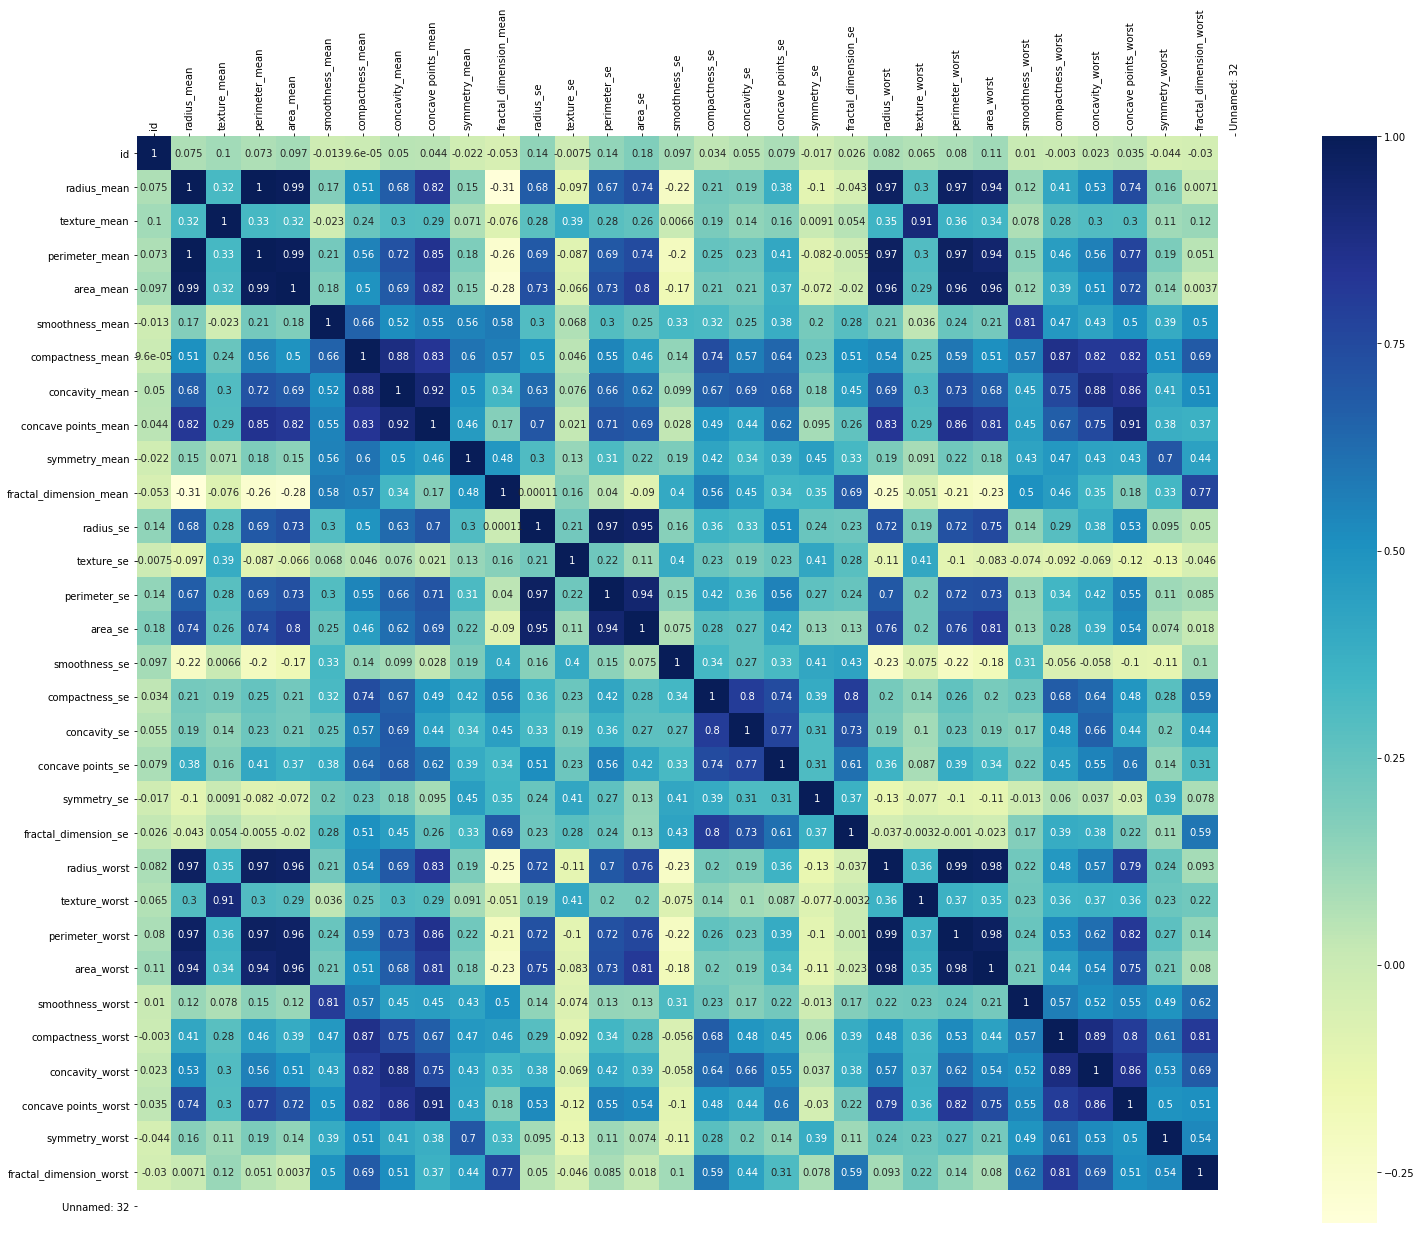

In [14]:
#plot a correlation heatmap
plt.subplots(figsize=(25,20))
hm1 = sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
hm1.set_xticklabels(hm1.get_xticklabels(), rotation=90)
hm1.xaxis.set_ticks_position('top')

This correlation heatmap helps with feature selection because the gradient shows the correlation between the columns of the dataframe. In order to select only the *significant* predictors, you must eliminate features that are highly correlated with each other **(ex: 0.95)**.

With respect to predicting the labels, the most significant predictors can be found by plotting boxplots of the numerical values against the labels. The features with boxplots that show the most variance should be chosen as the predictors for your model.

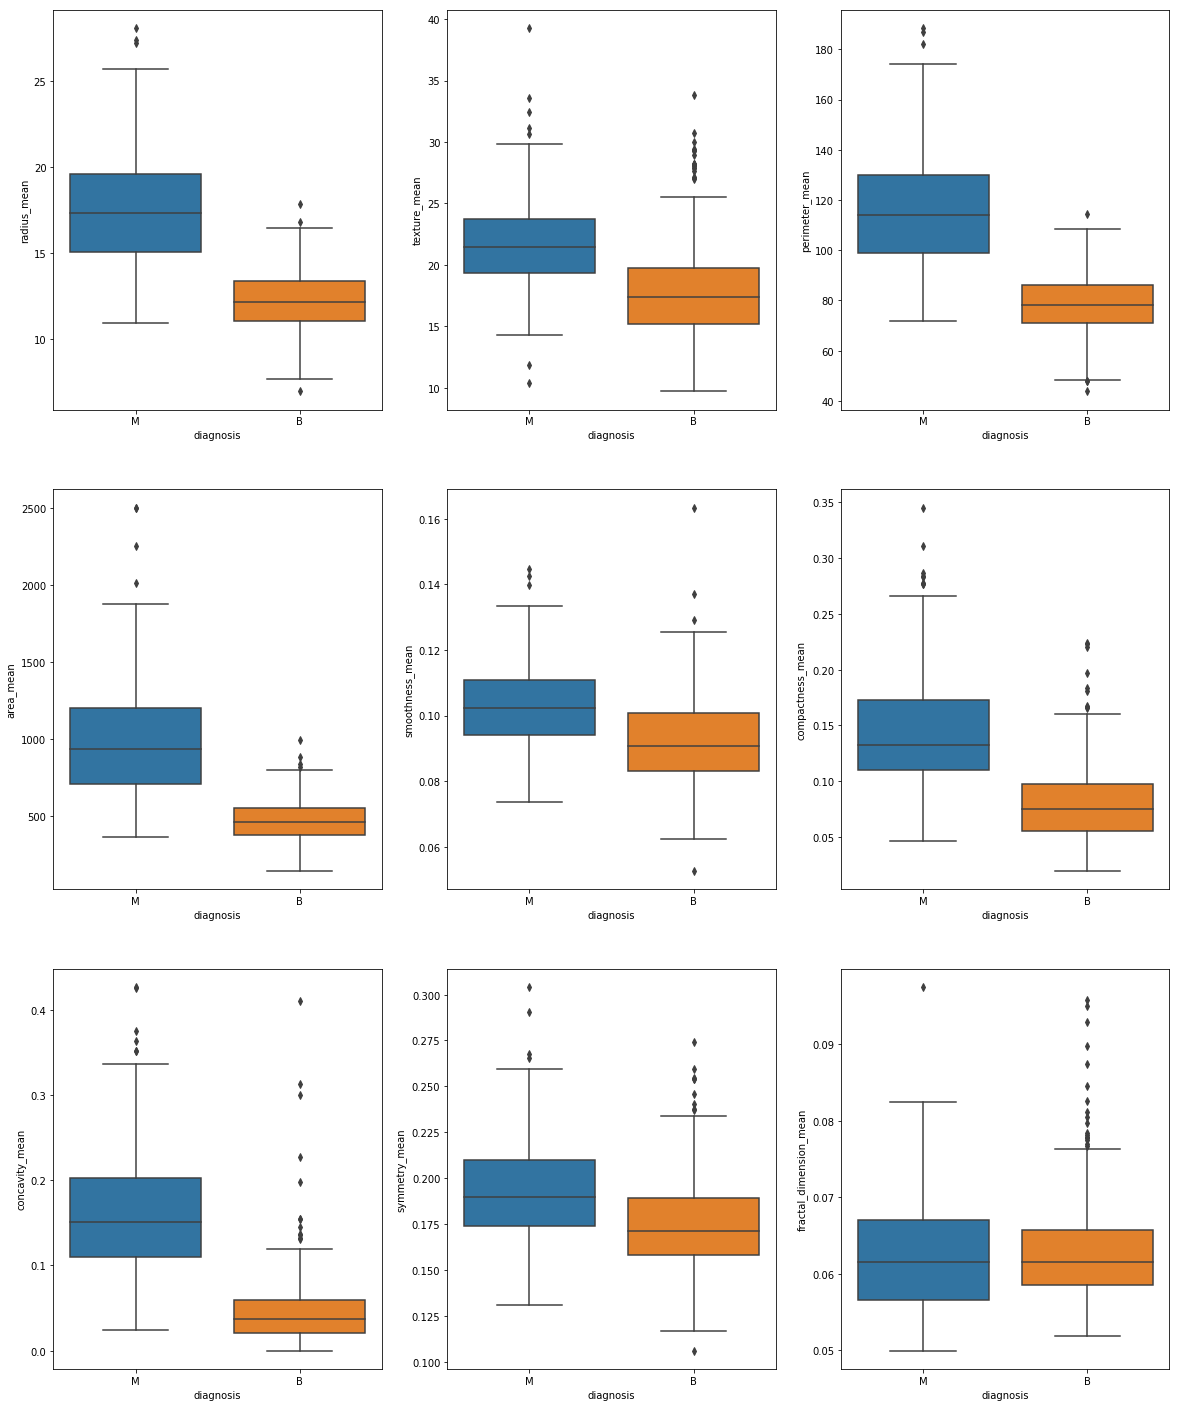

In [15]:
# plot boxplots of numerical columns
cont_list = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean']
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(cont_list)):
    sns.boxplot(x = 'diagnosis', y = cont_list[i], data=df, ax=ax[i])

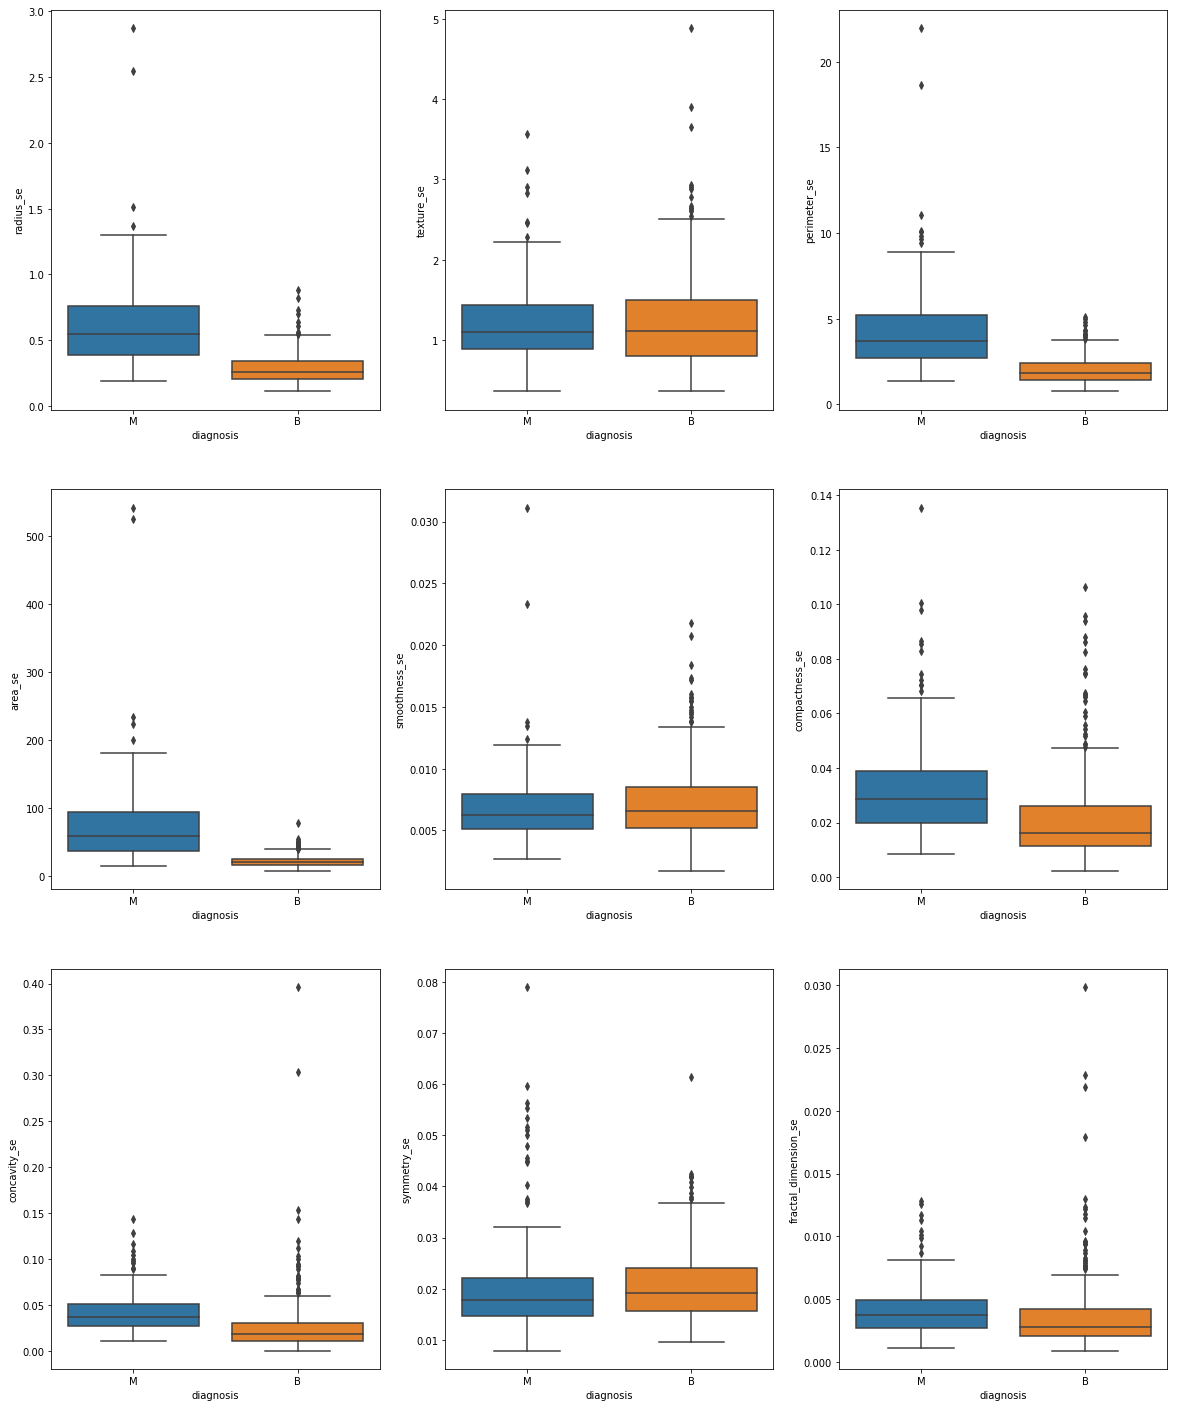

In [16]:
# Plot boxplots of numerical columns.
cont_list2 = ['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'symmetry_se', 'fractal_dimension_se']
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(cont_list2)):
    sns.boxplot(x = 'diagnosis', y = cont_list2[i], data=df, ax=ax[i])

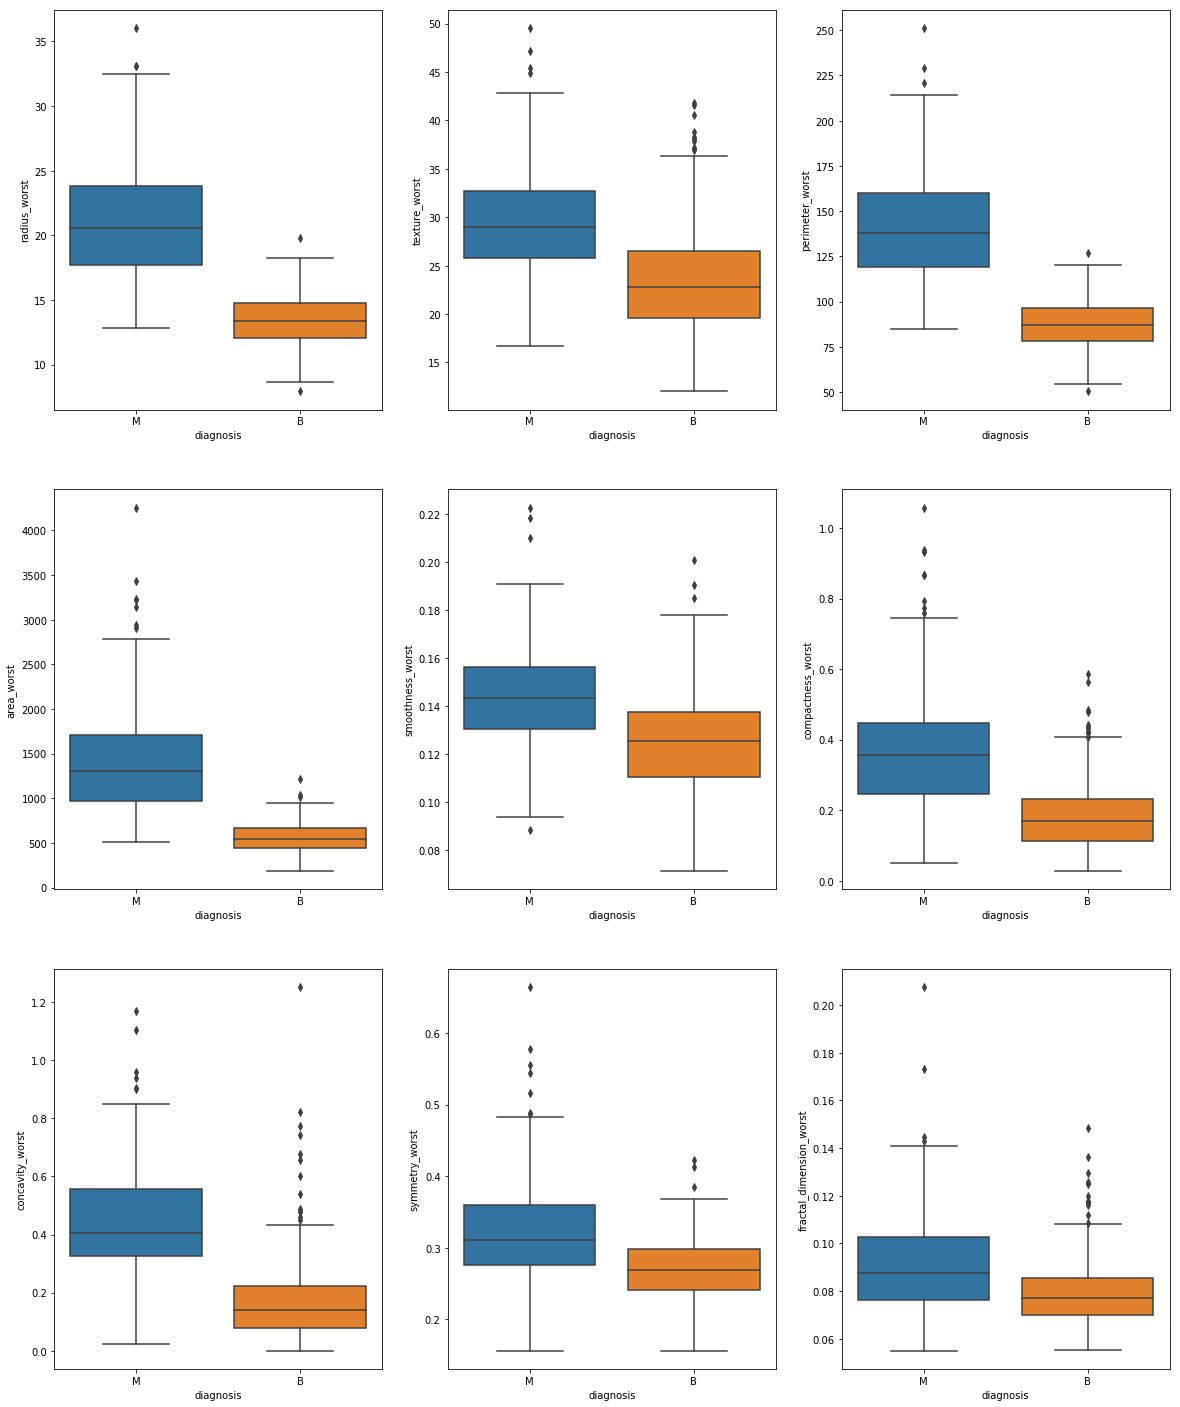

In [17]:
# Plot boxplots of numerical columns.
cont_list3 = ['radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'symmetry_worst', 'fractal_dimension_worst']
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(cont_list3)):
    sns.boxplot(x = 'diagnosis', y = cont_list3[i], data=df, ax=ax[i])

Here are boxplots of the most significant features:

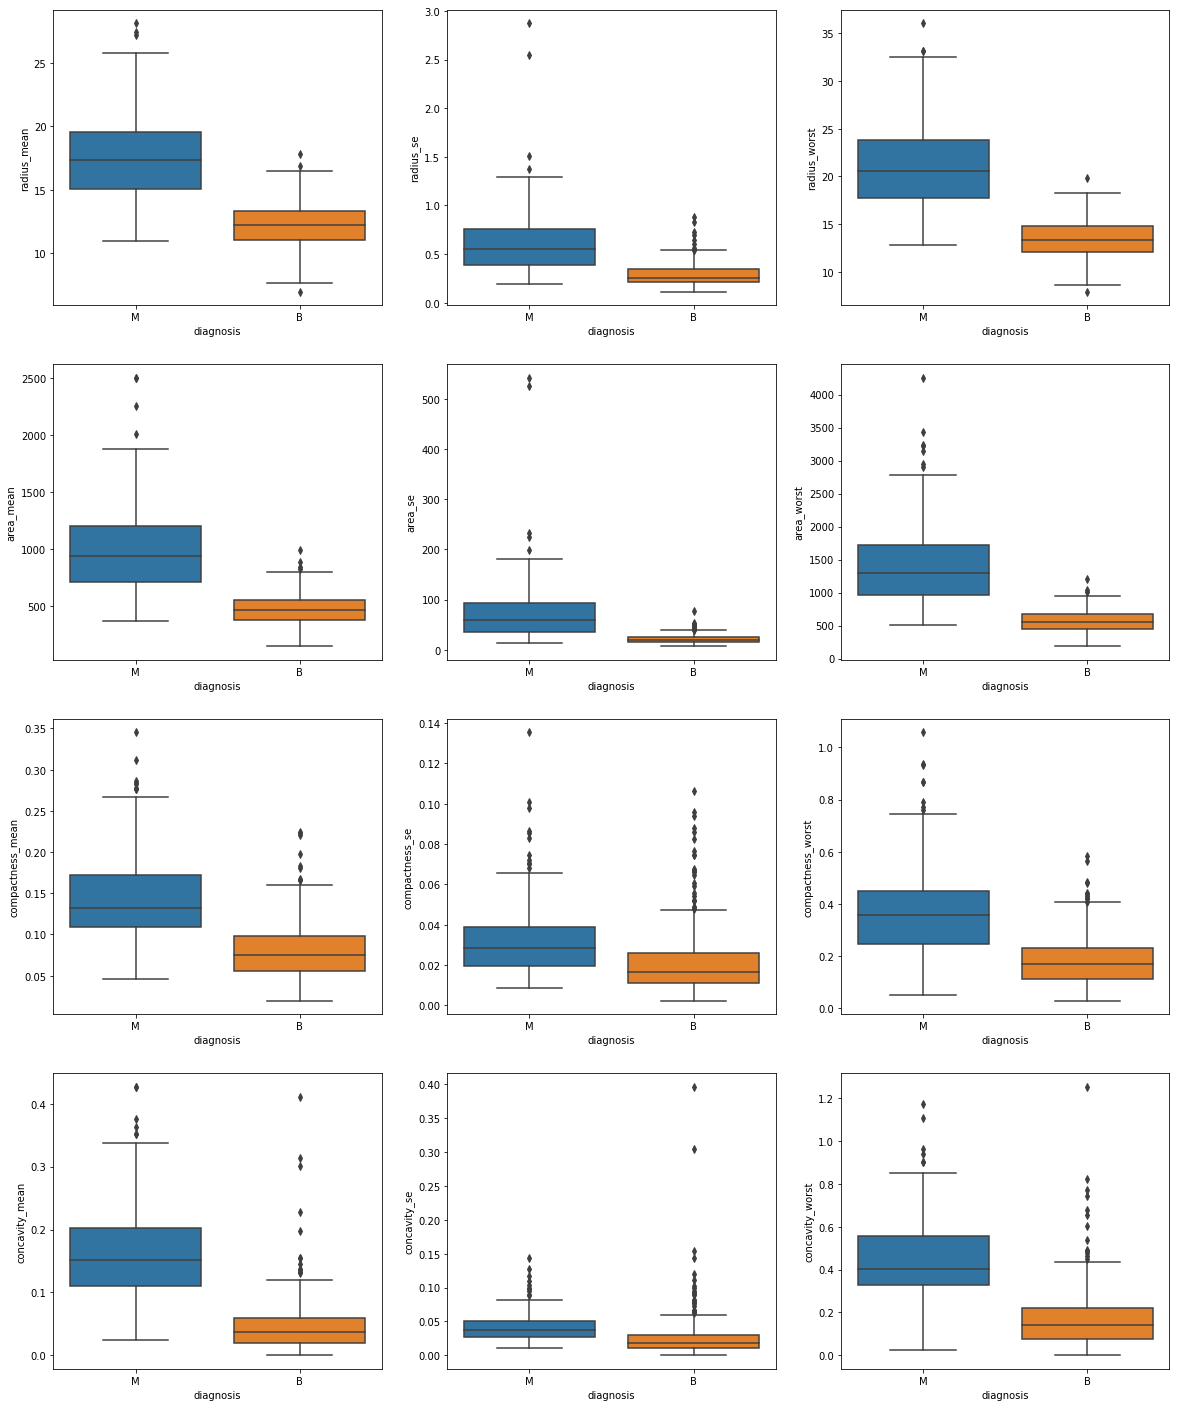

In [18]:
# Compare boxplots of significant numerical columns.
cont_list4 = ['radius_mean', 'radius_se', 'radius_worst', 'area_mean', 'area_se', 'area_worst', 'compactness_mean', 'compactness_se', 'compactness_worst', 'concavity_mean', 'concavity_se', 'concavity_worst']
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

for i in range(len(cont_list4)):
    sns.boxplot(x = 'diagnosis', y = cont_list4[i], data=df, ax=ax[i])

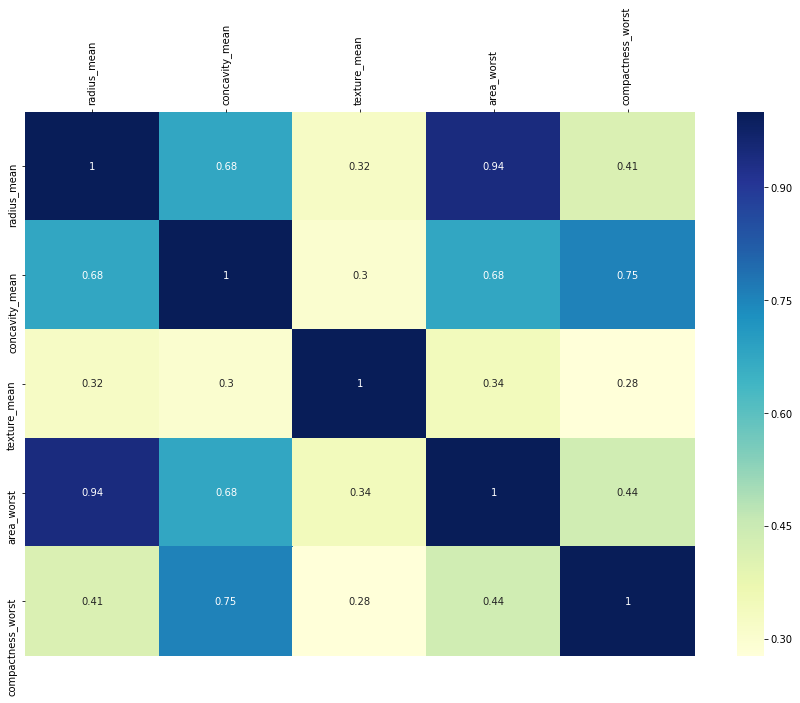

In [19]:
cont_list_f = ['radius_mean', 'concavity_mean', 'texture_mean', 'area_worst', 'compactness_worst']
plt.subplots(figsize=(15,10))
hm2 = sns.heatmap(df[cont_list_f].corr(), annot=True, cmap='YlGnBu')
hm2.set_xticklabels(hm2.get_xticklabels(), rotation=90)
hm2.xaxis.set_ticks_position('top')

By plotting the boxplots of each numerical column against the diagnosis type, we have picked out the significant features/predictors. More variation in the boxplot implies higher significance. We also eliminate features that are highly correlated. Therefore we can choose *radius_mean, radius_se, compactness_worst, concavity_mean, texture_mean* as the predictors for our model.

<a id='model'></a>
## 3. Create an XGBoost model

In this section, you will learn how to train and test an XGBoost model.

- [3.1 Split data](#prepare)
- [3.2 Create an XGBoost model](#create)

### 3.1 Split data<a id='prepare'></a>

You will pass the data with the selected significant predictors to build the model. You will use the `diagnosis` column as your target variable.

In [20]:
# Choosing the significant predictors.

X = df.iloc[:, [1,2,7,24,26]]
X = X.values

# Changing the target variables to binary variables
y = (df['diagnosis'] == 'M').astype(int)
y = y.values

Split the data set into: 
- Train data set
- Test data set

In [21]:
!pip install scikit-learn==0.19.1

     |████████████████████████████████| 12.4MB 6.8MB/s eta 0:00:01
ERROR: category-encoders 2.0.0 has requirement scikit-learn>=0.20.0, but you'll have scikit-learn 0.19.1 which is incompatible.
ERROR: autoai-libs 1.10.3 has requirement numpy>=1.16.4, but you'll have numpy 1.15.4 which is incompatible.
ERROR: autoai-libs 1.10.3 has requirement pandas>=0.24.2, but you'll have pandas 0.24.1 which is incompatible.
ERROR: autoai-libs 1.10.3 has requirement scikit-learn==0.20.3, but you'll have scikit-learn 0.19.1 which is incompatible.
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3


In [22]:
# Split the data set and create two data sets.
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=143)

In [23]:
# List the number of records in each data set.
print('Number of training records: ' + str(len(X_train)))
print('Number of testing records : ' + str(len(X_test)))

Number of training records: 369
Number of testing records : 200


The data has been successfully split into two data sets:
- The train data set which is the largest group will be used for training.
- The test data set will be used for model evaluation and is used to test the assumptions of the model.

### 3.2 Create an XGBoost model<a id='create'></a>

Install required packages.

**Tip:** Make sure `xgboost`'s version is 0.80.

In [24]:
!pip install 'xgboost==0.80'

     |████████████████████████████████| 15.8MB 5.6MB/s eta 0:00:01


In [25]:
import xgboost
xgboost.__version__

'0.80'

In [26]:
# Import packages you need to create the XGBoost model.
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#### 3.2.1 Create an XGBoost classifier

In this subsection, you will create an XGBoost classifier with default hyperparameters and you will call *xgb_model*. 

**Note**: The next sections show you how to improve this base model.

In [27]:
# Create the XGB classifier - xgb_model.
xgb_model = XGBClassifier(n_estimators=100)

Display the default parameters for *xgb_model*.

In [28]:
# List the default parameters.
print(xgb_model.get_xgb_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 1}


Now, that your XGBoost classifier *xgb_model* is set up, you can train it by using the fit method. You will also evaluate *xgb_model* as the train and test data are being trained.

In [29]:
# Train and evaluate.
xgb_model.fit(X_train, y_train, eval_metric=['error'], eval_set=[((X_train, y_train)),(X_test, y_test)])

ValueError: could not convert string to float: 'M'

Plot the model performance evaluated during the training process to assess model overfitting.

In [ ]:
# Plot and display the performance evaluation
xgb_eval = xgb_model.evals_result()
eval_steps = range(len(xgb_eval['validation_0']['error']))

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 6))

ax.plot(eval_steps, [1-x for x in xgb_eval['validation_0']['error']], label='Train')
ax.plot(eval_steps, [1-x for x in xgb_eval['validation_1']['error']], label='Test')
ax.legend()
ax.set_title('Accuracy')
ax.set_xlabel('Number of iterations')

You can see that there is model overfitting, and there is no increase in model accuracy after about 40 iterations.

Select the trained model obtained after 40 iterations.

In [ ]:
# Select trained model.
n_trees = 40
y_pred = xgb_model.predict(X_test, ntree_limit= n_trees)

In [ ]:
# Check the accuracy of the trained model.
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy: %.2f%%' % (accuracy * 100.0))

**Note:** You will use the test data accuracy to compare the accuracy of the model with *default* parameters to the accuracy of the model with *tuned* parameters.

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm)
plt.colorbar()
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()
pd.DataFrame(cm)

This confusion matrix maps the predicted values against the actual values. Here, you can see that 126 benign tumors and 66 malignant tumors have been predicted correctly. However, 8 benign tumors have been incorrectly predicted as malignant. 

In [ ]:
y_pred_prob = xgb_model.predict_proba(X_test)

# ROC-AUC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

This is the ROC-AUC curve - the area under the curve represents the accuracy of the predictions. You can see that the area under the curve is large, indicating that the predictions are highly accurate.

#### 3.2.2 Use grid search and cross-validation to tune the model 

You can use grid search and cross-validation to tune your model to achieve better accuracy.

**Note**: Grid search is used for this model as an example, but it is **not** recommended for small data sets such as this one, as it might lead to overfitting.

XGBoost has an extensive catalog of hyperparameters which provides great flexibility to shape an algorithm’s desired behavior. Here you will the optimize the model tuning which adds an L1 penalty (`reg_alpha`).

Use a 5-fold cross-validation because your training data set is small.

In the cell below, create the XGBoost pipeline and set up the parameter grid for the grid search.

In [ ]:
# Create XGBoost pipeline, set up parameter grid.
xgb_model_gs = XGBClassifier()
parameters = {'reg_alpha': [0.0, 1.0, 2.0], 'reg_lambda': [0.0, 1.0, 2.0], 'n_estimators': [n_trees], 'seed': [1337]}

Use ``GridSearchCV`` to search for the best parameters from the specified values in the previous cell.

In [ ]:
# Search for the best parameters.
clf = GridSearchCV(estimator = xgb_model_gs, param_grid = parameters, scoring='accuracy', cv=5, verbose=1, n_jobs=1, refit=True)
clf.fit(X_train, y_train)

You can see the cross validation results that were evaluated by the grid search.

In [ ]:
# Print model cross validation results.
for key in ['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']:
    print(str(key) + ': \n' + str(clf.cv_results_[key]) + '\n\n')

Display the accuracy estimated using cross-validation and the hyperparameter values for the best model.

In [ ]:
print('Best score: %.1f%%' % (clf.best_score_*100))
print('Best parameter set: %s' % (clf.best_params_))

Display the accuracy of the best parameter combination on the test set.

In [ ]:
y_pred = clf.best_estimator_.predict(X_test, ntree_limit= n_trees)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

The test set's accuracy is about the same for both the tuned model and the trained model with default hyperparameter values, even though the tuned hyperparameters are different from the default parameters.

#### 3.2.3 Model with pipeline data preprocessing

In this subsection, you will learn how to use the XGBoost model within the scikit-learn pipeline. 

Let's start by importing the required modules.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=5)
xgb_model_pca = XGBClassifier(n_estimators=n_trees)
pipeline = Pipeline(steps=[('pca', pca), ('xgb', xgb_model_pca)])

In [ ]:
pipeline.fit(X_train, y_train)

Now, you are ready to evaluate the accuracy of the model trained on the reduced set of features.

In [ ]:
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

You can see that this model has an accuracy similar to the model trained using default hyperparameters.

Let's see how you can save the XGBoost pipeline using the WML service instance and deploy it for online scoring.

<a id='persistence'></a>
## 4. Persist the model

In this section, you will learn how to use the `watson-machine-learning-client` package to store your XGBoost model in the WML repository.

In [ ]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [ ]:
!pip install --upgrade watson-machine-learning-client

In [ ]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

Authenticate the Watson Machine Learning service on the IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-get-wml-credentials.html" target="_blank" rel="noopener no referrer">Service Credentials</a> tab of the service instance that you created on the IBM Cloud. <BR>If you cannot find the **instance_id** field in **Service Credentials**, click **New credential (+)** to generate new authentication information. 

**Action**: Enter your Watson Machine Learning service instance credentials here.

In [ ]:
wml_credentials = {
    "apikey": "***",
    "instance_id": "***",
    "password": "***",
    "url": "https://ibm-watson-ml.mybluemix.net",
    "username": "***"
}

In [ ]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### 4.1 Save the XGBoost model in the WML Repository

Save the model artifact as *XGBoost model for breast cancer* to your WML instance.

In [ ]:
model_props = {client.repository.ModelMetaNames.NAME: 'XGBoost model for breast cancer'}
model_details = client.repository.store_model(pipeline, model_props)

In [ ]:
print(model_details)

Get the saved model metadata from WML.

# 5. Deploy and score in the WML repository <a id="scoring"></a>


In this section, you will learn how to create online scoring and score a new data record in the WML repository.

You can list all stored models using the  `list_models` method.

In [ ]:
# Display a list of all the models.
client.repository.list_models()

You need the model uid to create the deployment. You can extract the model uid from the saved model details.

In [ ]:
# Extract the uid.
model_uid = client.repository.get_model_uid(model_details)
print(model_uid)

Use this modul_uid in the next section to create the deployment.

### 5.1 Create a model deployment

Now, you can create a deployment, *Predict breast cancer*.

In [ ]:
# Create the deployment.
deployment_details = client.deployments.create(model_uid, 'Predict breast cancer')

Get the list of all deployments.

In [ ]:
# List the deployments.
client.deployments.list()

The *Predict breast cancer* model has been successfully deployed.

### 5.2 Perform prediction

Now, extract the url endpoint, *scoring_url*, which will be used to send scoring requests.

In [ ]:
# Extract endpoint url and display it.
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

Prepare the scoring payload with the values to score.

In [ ]:
# Prepare scoring payload.
payload_scoring = {'values': [list(X_test[0]), list(X_test[1])]}
print(payload_scoring)

In [ ]:
# Perform prediction and display the result.
import json
response_scoring = client.deployments.score(scoring_url, payload_scoring)
print(json.dumps(response_scoring, indent=2))

**Result**: The patient records are classified as a benign tumor and a malignant tumor respectively.

<a id='summary'></a>
## 6. Summary and next steps     

We have learned how to use a machine learning algorithm called XGBoost as well as Watson Machine Learning to create and deploy a model. 